# Importowanie niezbędnych bibliotek

In [2]:
# Importy standardowej biblioteki
import sys
import os

# Dodaj katalog główny projektu do sys.path
current_dir = (
    os.path.dirname(os.path.abspath(__file__))
    if "__file__" in globals()
    else os.getcwd()
)
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Katalog główny projektu: {project_root}")
print(f"Czy katalog src istnieje: {os.path.exists(os.path.join(project_root, 'src'))}")

import glob
from datetime import datetime

# Importy bibliotek zewnętrznych
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Importy własnych modułów
from src.config import (
    BATCH_SIZE,
    DEVICE,
    TEST_SPLIT,
    CLASS_NAMES,
    FEATURE_RESULTS_DIR,
    PROCESSED_FEATURES_DIR,
    ENSEMBLE_OUTPUT_DIR,
    OPTUNA_TRIALS,
    OPTUNA_TIMEOUT,
    CV_FOLDS,
    SEED,
)

from src.helpers.resnet_model_definition import AudioResNet

from src.helpers.ensemble_trainer import EnsembleModelTrainer


# Ustawienie domyślnego urządzenia
print(f"Using device: {DEVICE}")

Katalog główny projektu: c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition
Czy katalog src istnieje: True
Using device: cpu


## Automatyczna konfiguracja modelu ensemble

### Funkcja `find_latest_model`
**Opis:**  
Ta funkcja wyszukuje najnowszy plik modelu dla określonego typu cechy audio w katalogu z wynikami. Wykorzystuje wzorzec nazwy pliku, aby znaleźć wszystkie modele dla danego typu cechy, a następnie sortuje je według daty w nazwie pliku, zwracając najnowszy.

**Uzasadnienie:**  
Wybór najnowszego modelu jest kluczowy w procesie ensemble, ponieważ zapewnia, że używane są najbardziej aktualne wyniki treningu, co może wpływać na lepszą dokładność predykcji.

### Funkcja `find_feature_file`
**Opis:**  
Funkcja ta wyszukuje plik z cechami audio dla określonego typu reprezentacji w katalogu z przetworzonymi cechami. Jeśli znajdzie więcej niż jeden plik, wybiera najnowszy na podstawie daty modyfikacji.

**Uzasadnienie:**  
Wybór odpowiedniego pliku z cechami jest niezbędny do zapewnienia, że dane wejściowe do modelu są aktualne i zgodne z typem cechy, co pozwala na spójność między danymi a modelem podczas predykcji lub treningu.

### Funkcja `auto_configure_ensemble`
**Opis:**  
Funkcja automatycznie konfiguruje model ensemble, wyszukując dostępne typy cech w katalogu wyników, znajdując odpowiednie modele i pliki cech dla każdego typu, a następnie tworząc konfigurację z modelami, plikami cech, wagami początkowymi i parametrami eksperymentu.
W tym fragmencie kodu definiowana jest struktura config jako słownik, który zawiera kluczowe ustawienia modelu ensemble. Obejmuje ścieżki do modeli (model_paths) i plików cech (feature_files), klasę modelu (AudioResNet z pliku resnet_model_definition.py), początkowe wagi dla ensemble (initial_weights), katalog wyjściowy (output_dir z config.py), nazwę eksperymentu, podział danych na testowe (test_split), rozmiar partii (batch_size), parametry optymalizacji Optuna (optimization), nazwy klas emocji (class_names) oraz ziarno losowości (random_seed), z których większość pochodzi z pliku config.py.

**Uzasadnienie:**  
Automatyczna konfiguracja pozwala na szybkie zestawienie modelu ensemble bez konieczności ręcznego określania ścieżek do modeli i plików cech, co minimalizuje ryzyko błędów ludzkich i przyspiesza proces przygotowania do treningu lub testowania. Funkcja sprawdza również, czy wszystkie wymagane pliki istnieją, co zapobiega problemom podczas dalszej pracy. Konfiguracja config centralizuje wszystkie parametry potrzebne do treningu i testowania modelu ensemble, zapewniając spójność między ustawieniami projektu (config.py), architekturą modelu (resnet_model_definition.py) a danymi, co ułatwia automatyzację i powtarzalność eksperymentów.


In [9]:
def find_latest_model(feature_type):
    """Zwraca najnowszy model dla danej reprezentacji audio."""
    search_pattern = (
        f"{FEATURE_RESULTS_DIR}/{feature_type}/best_model_{feature_type}_*.pt"
    )
    model_files = glob.glob(search_pattern)

    if not model_files:
        return None

    # Sortowanie plików według daty w nazwie (najnowszy na końcu)
    model_files.sort(key=lambda x: os.path.basename(x).split("_")[-1].split(".")[0])
    return model_files[-1]


def find_feature_file(feature_type):
    """Zwraca plik z cechami dla danej reprezentacji audio."""
    search_pattern = f"{PROCESSED_FEATURES_DIR}/{feature_type}_*.pkl"
    feature_files = glob.glob(search_pattern)

    if not feature_files:
        return None

    # W przypadku wielu plików, wybór najnowszego
    if len(feature_files) > 1:
        feature_files.sort(key=os.path.getmtime, reverse=True)

    return feature_files[0]


def auto_configure_ensemble(feature_types=None):
    """
    Konfiguracja modelu ensemble w sposób automatyczny.
    """
    # Wykorzystanie zmiennych z config.py
    if feature_types is None:
        try:
            feature_types = [
                d
                for d in os.listdir(FEATURE_RESULTS_DIR)
                if os.path.isdir(os.path.join(FEATURE_RESULTS_DIR, d))
            ]
        except FileNotFoundError:
            raise FileNotFoundError(f"Nie znaleziono katalogu '{FEATURE_RESULTS_DIR}'.")

    print(f"Typy cech wybrane do modelu ensemble: {', '.join(feature_types)}")

    model_paths = {}
    feature_files = {}
    initial_weights = {}
    missing_feature_files = []

    for feature_type in feature_types:
        # Weryfikacja pliku cech
        feature_file = find_feature_file(feature_type)
        if not feature_file:
            missing_feature_files.append(feature_type)
            print(f"Ostrzeżenie: Brak pliku cech dla {feature_type}")
            continue  # Kontynuacja do następnego typu, bez szukania modelu, gdy brak cech

        feature_files[feature_type] = feature_file

        # Wyszukiwanie modelu
        model_path = find_latest_model(feature_type)
        if model_path:
            model_paths[feature_type] = model_path
            initial_weights[feature_type] = (
                1.0  # Waga do normalizacji w późniejszym etapie
            )
        else:
            print(
                f"Ostrzeżenie: Brak modelu dla {feature_type}, mimo istnienia pliku cech."
            )
            # Decyzja o kontynuacji bez tego modelu lub zgłoszenie błędu.
            # Na razie pominięcie tego typu cechy w modelu.
            del feature_files[
                feature_type
            ]  # Usunięcie wpisu o pliku cech, gdy brak modelu

    # W przypadku brakujących plików cech, zgłoszenie błędu
    if missing_feature_files:
        error_message = (
            f"Błąd: Brak plików cech dla: {', '.join(missing_feature_files)}. "
            f"Zaleca się uruchomienie funkcji `process_dataset` w pliku `ResNet_porównanie.ipynb`, "
            f"aby wygenerować brakujące pliki w folderze `src/ResNet_for_all_repr/processed_features`."
        )
        raise FileNotFoundError(error_message)

    # Weryfikacja, czy znaleziono jakiekolwiek działające pary model-cechy
    if not model_paths:
        raise ValueError(
            "Brak działających modeli i odpowiadających im plików cech! "
            "Zaleca się sprawdzenie folderów 'src/ResNet_for_all_repr/feature_comparison_results' i 'src/ResNet_for_all_repr/processed_features'."
        )

    # Normalizacja wag, aby sumowały się do 1
    num_features = len(model_paths)
    initial_weights = {k: 1.0 / num_features for k in model_paths.keys()}

    # Tworzenie konfiguracji
    config = {
        "model_paths": model_paths,
        "model_class": AudioResNet,
        "feature_files": feature_files,
        "initial_weights": initial_weights,
        "output_dir": ENSEMBLE_OUTPUT_DIR,
        "experiment_name": f"ensemble_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        "test_split": TEST_SPLIT,
        "batch_size": BATCH_SIZE,
        "optimization": {
            "n_trials": OPTUNA_TRIALS,
            "timeout": OPTUNA_TIMEOUT,
            "n_folds": CV_FOLDS,
        },
        "class_names": CLASS_NAMES,
        "random_seed": SEED,
    }

    print(f"\nZnaleziono {len(model_paths)} działających par model-cechy:")
    for feat in model_paths.keys():
        print(f"  - {feat}")

    return config

## Konfiguracja modelu ensemble z wybranymi cechami

In [17]:
# Automatyczne wykrywanie dostępnych modeli
# CONFIG = auto_configure_ensemble()

# Selekcja konkretnych reprezentacji
selected_features = ["melspectrogram", "mfcc", "hpss", "chroma", "tempogram"]
CONFIG = auto_configure_ensemble(feature_types=selected_features)

# Modyfikacja wygenerowanej konfiguracji w celu dostosowania liczby prób optymalizacji
# CONFIG["optimization"]["n_trials"] = 100  # Ustalenie liczby prób optymalizacji

Typy cech wybrane do modelu ensemble: melspectrogram, mfcc, hpss, chroma, tempogram

Znaleziono 5 działających par model-cechy:
  - melspectrogram
  - mfcc
  - hpss
  - chroma
  - tempogram


## Opis funkcji `auto_configure_ensemble`:
Funkcja `auto_configure_ensemble` w pliku `ResNet_ensemble.ipynb` automatycznie przygotowuje model ensemble, przeszukując katalogi zdefiniowane w `config.py` w poszukiwaniu najnowszych modeli i plików cech dla różnych reprezentacji audio. Tworzy konfigurację zawierającą ścieżki do modeli, pliki cech, klasę modelu `AudioResNet` (z resnet_model_definition.py), znormalizowane wagi początkowe oraz parametry eksperymentu i optymalizacji.
## Uzasadnienie architektury i featurów:
Architektura ensemble łączy predykcje różnych modeli bazowych, analizujących odmienne cechy audio, co pozwala lepiej uchwycić emocje w dźwięku. W szczególności model ensemble osiągnął najlepsze wyniki po kilku próbach z różnymi konfiguracjami, wykorzystując trzy reprezentacje: chroma (harmonia i tony), melspectrogram (częstotliwości dostosowane do ludzkiego słuchu) oraz mfcc (cechy cepstralne istotne w analizie mowy). Automatyzacja konfiguracji oszczędza czas i minimalizuje błędy, umożliwiając skupienie się na analizie wyników.
## Analiza pliku `ensemble_trainer.py`:
Plik `ensemble_trainer.py` definiuje klasę `EnsembleModelTrainer`, która zarządza trenowaniem i oceną modelu ensemble. Odpowiada za ładowanie modeli   `AudioResNet` i danych cech, optymalizację wag za pomocą Optuna (z parametrami z `config.py`), ocenę modelu na zbiorze testowym, generowanie macierzy pomyłek oraz analizę błędów. Wykorzystuje MLflow do logowania eksperymentów, a walidacja krzyżowa i podział danych (zgodnie z `TEST_SPLIT`) zapewniają rzetelność wyników.

Zastosowanie ensemble z wybranymi cechami audio (chroma, melspectrogram, mfcc) pozwala uchwycić złożoność emocji w dźwiękach, a modularna struktura `EnsembleModelTrainer` ułatwia zarządzanie eksperymentami. Automatyzacja optymalizacji wag i logowanie wyników wspierają efektywność i powtarzalność, co jest kluczowe w badaniach nad rozpoznawaniem emocji.

In [18]:
# Inicjalizacja konfiguracji
if "CONFIG" not in locals():
    try:
        print("Rozpoczynanie automatycznego generowania konfiguracji...")
        CONFIG = auto_configure_ensemble()
    except Exception as e:
        raise NameError(
            f"Zmienna CONFIG nie jest zdefiniowana i nie udało się jej automatycznie wygenerować: {e}. Należy najpierw uruchomić komórkę konfiguracyjną lub upewnić się, że pliki modeli/cech są dostępne."
        )

# Tworzenie głównego katalogu wyjściowego dla bieżącego uruchomienia
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Wykorzystanie podstawowego output_dir z konfiguracji
base_output_dir = CONFIG.get("output_dir", "ensemble_outputs")
output_dir = os.path.join(base_output_dir, f"ensemble_run_{timestamp}")
os.makedirs(output_dir, exist_ok=True)
print(f"Główny katalog wyjściowy utworzony: {output_dir}")

# Inicjalizacja trenera z odpowiednim output_dir
trainer = EnsembleModelTrainer(
    model_paths=CONFIG["model_paths"],
    feature_files=CONFIG["feature_files"],
    model_class=CONFIG["model_class"],
    output_dir=output_dir,
)


print("Inicjalizacja zakończona. Można przystąpić do optymalizacji lub treningu.")

Główny katalog wyjściowy utworzony: c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\ensemble_outputs\ensemble_run_20250523_193302
Próba załadowania modelu dla cechy 'melspectrogram' z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/melspectrogram\best_model_melspectrogram_20250523_120505.pt
Model załadowany pomyślnie z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/melspectrogram\best_model_melspectrogram_20250523_120505.pt
Pomyślnie załadowano model dla cechy 'melspectrogram'
Próba załadowania modelu dla cechy 'mfcc' z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/mfcc\best_model_mfcc_20250523_122042.pt
Model załadowany pomyślnie z c:\Users\kubas\Desktop\Projekt dyplomowy\Audio-Emotion-Recognition\src\feature_comparison_results/mfcc\best_model_mfcc_20250523_122042.pt
Pomyślnie załadowano model dla cechy 'mfcc'
P

## Optymalizacja wag

Poniżej pobierane są parametry optymalizacji z wcześniej zdefiniowanej konfiguracji `CONFIG`, takie jak liczba prób (`n_trials`), limit czasu (`timeout`), liczba foldów walidacji krzyżowej (`n_folds`) oraz proporcja danych testowych (`test_size`). Następnie wywoływana jest metoda `optimize_weights` obiektu `trainer`, która wykorzystuje bibliotekę **Optuna** do znalezienia najlepszych wag dla każdego modelu bazowego w ensemble. Na koniec wyświetlane są informacje o zakończeniu optymalizacji oraz uzyskane najlepsze wagi (`best_weights`).

Optymalizacja wag jest kluczowym krokiem w budowie modelu ensemble, ponieważ pozwala określić, jak bardzo każdy model bazowy (dla różnych cech audio) wpływa na ostateczną predykcję. Użycie Optuna automatyzuje ten proces, testując różne kombinacje wag w oparciu o walidację krzyżową, co prowadzi do poprawy dokładności modelu. Logowanie parametrów i wyników zapewnia przejrzystość i możliwość analizy procesu optymalizacji.

In [19]:
# Komórka odpowiedzialna za optymalizację wag modelu
n_trials = CONFIG["optimization"]["n_trials"]
timeout = CONFIG["optimization"]["timeout"]
n_folds = CONFIG["optimization"]["n_folds"]
test_size = CONFIG["test_split"]

print(f"Rozpoczynanie optymalizacji z {n_trials} próbami...")
optimization_result = trainer.optimize_weights(
    n_trials=n_trials, timeout=timeout, n_folds=n_folds, test_size=test_size
)

print("Optymalizacja zakończona!")
print(f"Pełny wynik optymalizacji: {optimization_result}")

# Wydobycie wag z wyniku (optimization_result to krotka: (best_score, best_params))
best_score, best_weights = optimization_result
print(f"Najlepszy wynik: {best_score}")
print(f"Najlepsze wagi z Optuna: {best_weights}")

# Zapisz wagi do późniejszego użycia
optuna_weights = best_weights.copy()
print(f"Wagi zapisane jako 'optuna_weights': {optuna_weights}")

Rozpoczynanie optymalizacji z 50 próbami...


2025/05/23 19:33:04 INFO mlflow.tracking.fluent: Experiment with name 'ensemble_optimization_20250523_193304' does not exist. Creating a new experiment.
[I 2025-05-23 19:33:04,394] A new study created in memory with name: ensemble_optimization_20250523_193304
[I 2025-05-23 19:34:25,204] Trial 0 finished with value: 0.9841933984193397 and parameters: {'melspectrogram': 0.3745401188473625, 'mfcc': 0.9507143064099162, 'hpss': 0.7319939418114051, 'chroma': 0.5986584841970366, 'tempogram': 0.15601864044243652}. Best is trial 0 with value: 0.9841933984193397.
[I 2025-05-23 19:35:47,301] Trial 1 finished with value: 0.9860529986052998 and parameters: {'melspectrogram': 0.15599452033620265, 'mfcc': 0.05808361216819946, 'hpss': 0.8661761457749352, 'chroma': 0.6011150117432088, 'tempogram': 0.7080725777960455}. Best is trial 1 with value: 0.9860529986052998.
[I 2025-05-23 19:37:03,127] Trial 2 finished with value: 0.9846582984658299 and parameters: {'melspectrogram': 0.020584494295802447, 'mfcc'

Optymalizacja zakończona!
Pełny wynik optymalizacji: (0.9874476987447699, {'melspectrogram': 0.03346146518584171, 'mfcc': 0.07064311434205794, 'hpss': 0.9107569550094782, 'chroma': 0.06644435326531571, 'tempogram': 0.2252713266640483})
Najlepszy wynik: 0.9874476987447699
Najlepsze wagi z Optuna: {'melspectrogram': 0.03346146518584171, 'mfcc': 0.07064311434205794, 'hpss': 0.9107569550094782, 'chroma': 0.06644435326531571, 'tempogram': 0.2252713266640483}
Wagi zapisane jako 'optuna_weights': {'melspectrogram': 0.03346146518584171, 'mfcc': 0.07064311434205794, 'hpss': 0.9107569550094782, 'chroma': 0.06644435326531571, 'tempogram': 0.2252713266640483}


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## Trening i ewaluacja modelu

Komórka poniżej umożliwia elastyczne testowanie modelu ensemble z różnymi zestawami wag – zarówno zoptymalizowanymi automatycznie, jak i ustawionymi ręcznie, co pozwala eksperymentować z wpływem poszczególnych reprezentacji audio na wynik. Wywołanie metody `train_and_evaluate` integruje proces treningu i oceny, korzystając z wcześniej przygotowanej konfiguracji.

In [20]:
# Komórka odpowiedzialna za trening i ewaluację modelu
# Wybór wag: użyj wag z Optuna lub zdefiniuj własne

# OPCJA 1: Użyj wag z optymalizacji Optuna (z poprzedniej komórki)
use_optuna_weights = True

# OPCJA 2: Zdefiniuj własne wagi (ustaw use_optuna_weights = False)
custom_weights = {
    "chroma": 0.13857384163072003,
    "melspectrogram": 0.31651310994496806,
    "mfcc": 0.544913048424312,
}

# Wybierz które wagi użyć
if use_optuna_weights:
    weights_to_use = optuna_weights
    print(f"Używam wag z optymalizacji Optuna: {weights_to_use}")
else:
    weights_to_use = custom_weights
    print(f"Używam niestandardowych wag: {weights_to_use}")

# Trenowanie i ewaluacja modelu
print("Rozpoczynam trenowanie ensemble z wybranymi wagami...")
ensemble_model, test_results = trainer.train_and_evaluate(
    weights=weights_to_use,
    test_size=CONFIG["test_split"],
    batch_size=CONFIG["batch_size"],
)

print("Trenowanie i ewaluacja zakończona!")
print(f"Dokładność testowa: {test_results.get('accuracy', 0.0):.4f}")
print(f"Wynik F1 testu: {test_results.get('f1', 0.0):.4f}")
print(f"Użyte wagi: {weights_to_use}")

Używam wag z optymalizacji Optuna: {'melspectrogram': 0.03346146518584171, 'mfcc': 0.07064311434205794, 'hpss': 0.9107569550094782, 'chroma': 0.06644435326531571, 'tempogram': 0.2252713266640483}
Rozpoczynam trenowanie ensemble z wybranymi wagami...
Trenowanie i ewaluacja zakończona!
Dokładność testowa: 0.9465
Wynik F1 testu: 0.9464
Użyte wagi: {'melspectrogram': 0.03346146518584171, 'mfcc': 0.07064311434205794, 'hpss': 0.9107569550094782, 'chroma': 0.06644435326531571, 'tempogram': 0.2252713266640483}


## Szczegółowe wyniki modelu

Raport klasyfikacji:
              precision    recall  f1-score   support

       anger       0.97      0.97      0.97       150
        fear       0.96      0.96      0.96       147
   happiness       0.92      0.92      0.92       150
     neutral       0.97      0.96      0.97       162
     sadness       0.96      0.98      0.97       154
   surprised       0.89      0.88      0.88       134

    accuracy                           0.95       897
   macro avg       0.95      0.94      0.94       897
weighted avg       0.95      0.95      0.95       897



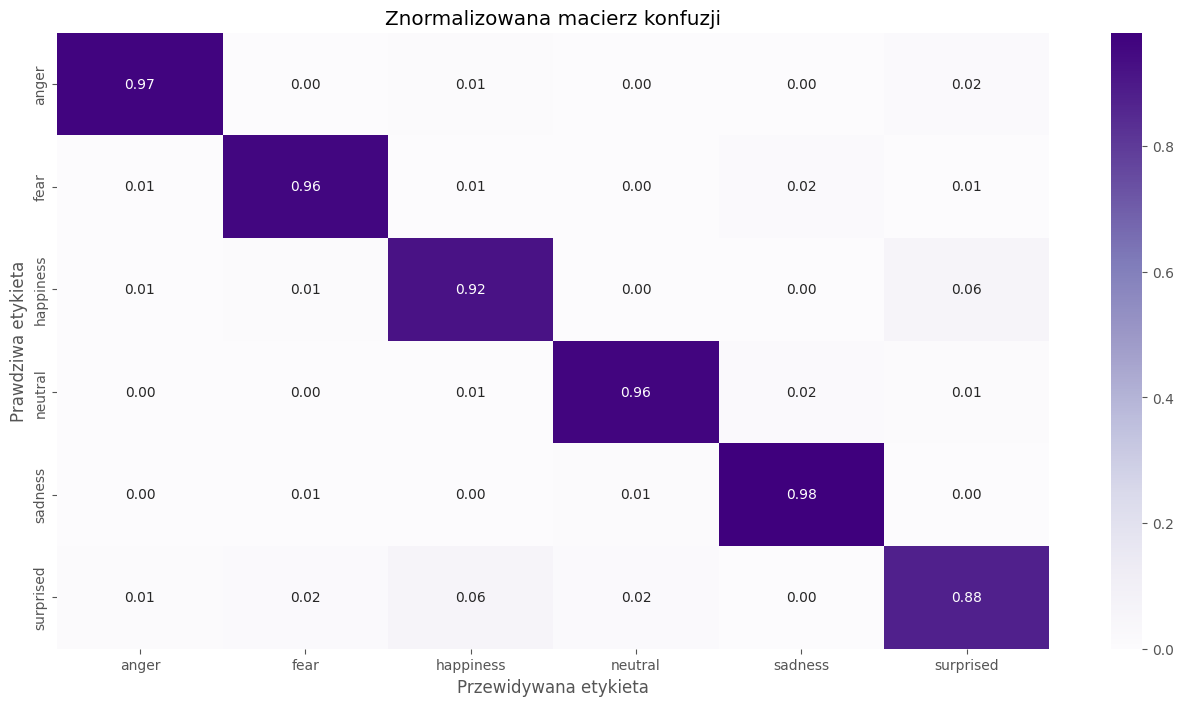

In [21]:
# Komórka odpowiedzialna za wyświetlanie szczegółowych wyników
# Wymagana po zakończeniu procesu treningu i ewaluacji
if "test_results" in locals():
    # Generowanie szczegółowego raportu klasyfikacji
    print("Raport klasyfikacji:")
    class_names = CONFIG["class_names"]
    print(
        classification_report(
            test_results["true"], test_results["preds"], target_names=class_names
        )
    )

    # Tworzenie i wyświetlanie znormalizowanej macierzy konfuzji
    plt.figure(figsize=(16, 8))
    cm_normalized = (
        test_results["cm"].astype("float")
        / test_results["cm"].sum(axis=1)[:, np.newaxis]
    )
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Znormalizowana macierz konfuzji")
    plt.ylabel("Prawdziwa etykieta")
    plt.xlabel("Przewidywana etykieta")
    plt.show()